# Tutorial on how to scrape data from stats.nba.com

This is my attempt at trying to scrape NBA player data from stats.nba.com. The main challenge with scraping from stats.nba.com is that their tables are dynamic, but conveniently, python package called **`selenium`** can be used to drive the web drive and interact with the dynamic table. After extracting stats from the website, I'm going to use pandas to create a dataframe, which can be stored as data frame pickle, json or sql database if you'd like. Here, I'll save the dataframe as pickle and sql database.


## Load up all the packages

```python
%matplotlib inline
from selenium import webdriver
from pandas import *
import pandas
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import *
```


## Loading up Chromedriver to make it look like a person is driving the website navigation

<br>
<br>

```python
path_to_chromedriver = '/path/to/chromedriver' # Path to access a chrome driver
browser = webdriver.Chrome(executable_path=path_to_chromedriver)
```

<br>
<br>

*Note: I use anaconda to manage my packages and control environments.*
*If you're using Anaconda, you can download a chromedriver by using:* <br>
**conda install -c clinicalgraphics chromedriver**



```python

url = 'https://stats.nba.com/leaders'
browser.get(url)
```

Here, we're accessing the web through the chromedriver that we opened up. You can change url variable to whatever website you'd like, and you should be able to get the site opened up on chromedriver.

# Getting the stats table we want

This part is probably the trickiest and the slickest part of using selenium. Now that we've accessed `stats.nba.com/leaders` we want through chromedriver, we need to interact with the table and pull out the table that we want. In our case I want to change 3 things about this:

*Note: the 3 areas need for change are annotated and numbered in the image*

1. The default option for season is 2017-2018 season. However, I want to inspect last year's (2016-17) season stats. So, we need to change this parameter.
<br>
2. Currently, the season type is set to be preseason, but who cares about the preseason??? We want to change this to regular season stat sheet.

    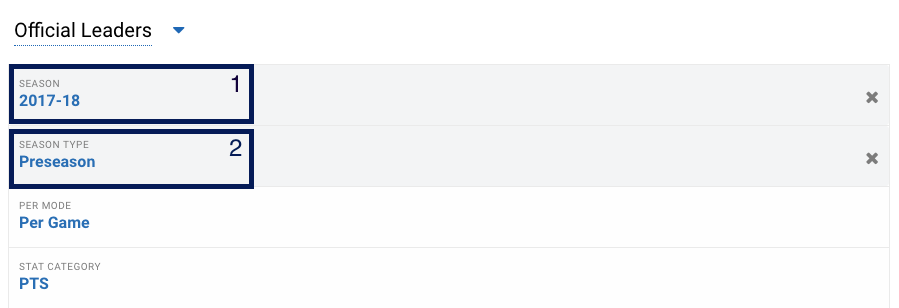

3. After we change the season year and type, we need to change the formate of the table, so that all players are displayed. This option is at the bottom of the page, and we need to change the option to "all."

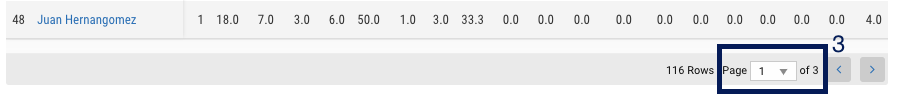


# Now, here's the trick

We're going to find these elements by using inspection and finding its xpath. In chrome, first right click on the dropdown menu and select Inspect. This will bring a new look to the chromedriver that looks like this following image:

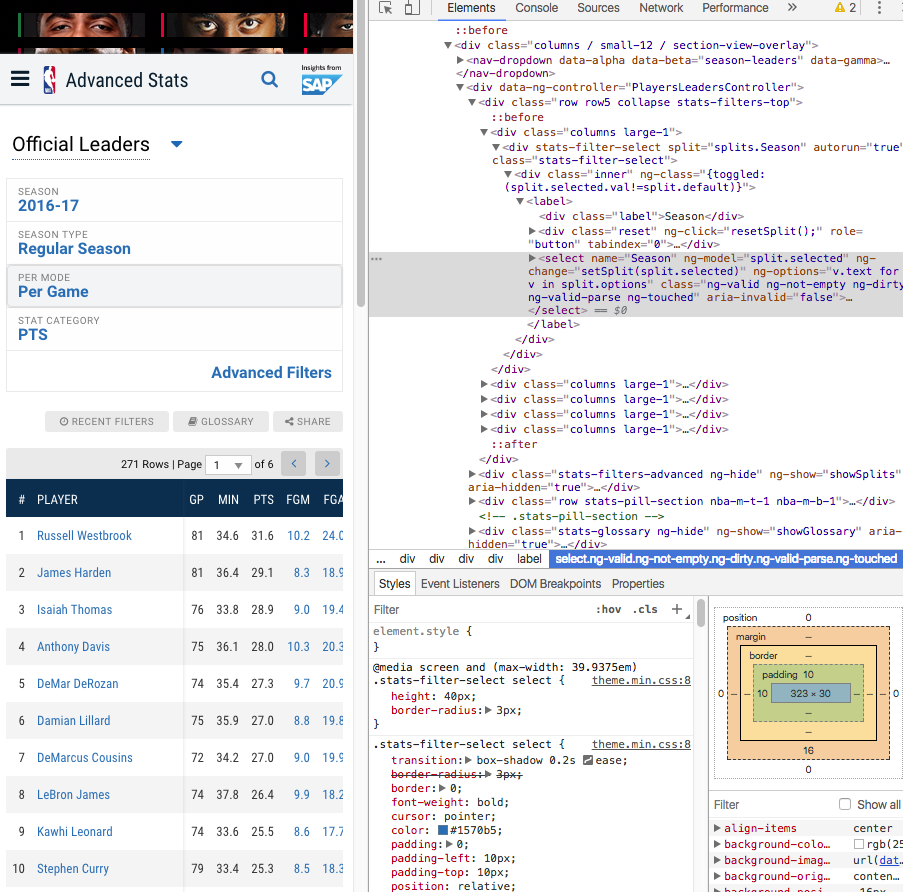

After you get to the inspection page, the dropdown menu that you selected to inspect should be highlighted on right side of the page. If you right click on the highlighted box on the right side, you have the option of copying its XPATH. 

For example, let's find the xpath for the season year:
<br>
`/html/body/main/div[2]/div/div[2]/div/div/div[1]/div[1]/div/div/label/select`
<br>

Okay, now we can use this xpath and options to get to the right season. To do this, we'll just add `/option[2]` at the end of the above xpath to get the 2016-17 season. So, the final product looks like ths following:
<br>
`/html/body/main/div[2]/div/div[2]/div/div/div[1]/div[1]/div/div/label/select/option[2]`
<br>

Now, we can use this xpath to get to the right table:
 
```python
browser.find_element_by_xpath('/html/body/main/div[2]/div/div[2]/div/div/div[1]/div[1]/div/div/label/select/option[2]').click()
```

After running the above command, your chromedriver shuold display the 2016-17 preseason stat table. Now let's use the same trick to get to the 2016-17 regular season stat table and show all players' stats.


```python
browser.find_element_by_xpath('/html/body/main/div[2]/div/div[2]/div/div/div[1]/div[2]/div/div/label/select/option[2]').click()

browser.find_element_by_xpath('/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[3]/div/div/select/option[1]').click()
```

# Finding the stat table

Now that we've successfully navigated to the right season + season type, we need to find the table in `html` to scrape. This part is quite easy. This is not the most elegant way of scraping the table, but it works. First, we go back to the inspect page, and you'll notice that the table is called `nba-stat-table__overflow`. So, we'll find this table by running the following line:
``` python
table = browser.find_element_by_class_name('nba-stat-table__overflow')
```

If you run print table.text(), you'll see that the first line of text is the column names, and then the following lines go in the order of player's ID, name and stats, and repeat.

So I wrote a somewhat stupid code for parsing this:

```python
player_ids = []
player_names = []
player_stats = []

for line_id, lines in enumerate(table.text.split('\n')):
    if line_id == 0:
        column_names = lines.split(' ')[1:]
    else:
        if line_id % 3 == 1:
            player_ids.append(lines)
        if line_id % 3 == 2:
            player_names.append(lines)
        if line_id % 3 == 0:
            player_stats.append( [float(i) for i in lines.split(' ')] )
```

# Creating a pandas dataframe

I like working with pandas because it's compatible with many different forms of databases, and it also provides nice tables in jupyter notebook. Here's how we're going to create our database:

``` python
db = pandas.DataFrame({'player': player_names,
                       'gp': [i[0] for i in player_stats],
                       'min': [i[1] for i in player_stats],
                       'pts': [i[2] for i in player_stats],
                       'fgm': [i[3] for i in player_stats], 
                       'fga': [i[4] for i in player_stats],
                       'fg%': [i[5] for i in player_stats],
                       '3pm': [i[6] for i in player_stats],
                       '3pa': [i[7] for i in player_stats],
                       '3p%': [i[8] for i in player_stats],
                       'ftm': [i[9] for i in player_stats],
                       'fta': [i[10] for i in player_stats],
                       'ft%': [i[11] for i in player_stats],
                       'oreb': [i[12] for i in player_stats],
                       'dreb': [i[13] for i in player_stats],
                       'reb': [i[14] for i in player_stats],
                       'ast': [i[15] for i in player_stats],
                       'stl': [i[16] for i in player_stats],
                       'blk': [i[17] for i in player_stats],
                       'tov': [i[18] for i in player_stats],
                       'eff': [i[19] for i in player_stats]
                       }
                     )
                     ```

One annoying thing is that all the column names are getting re-ordered in alphabetical order. So we're going to reorder this by the following line:
```python
db = db[['player', 
         'gp', 
         'min', 
         'pts', 
         'fgm', 
         'fga', 
         'fg%', 
         '3pm', 
         '3pa', 
         '3p%', 
         'ftm',
         'fta', 
         'ft%', 
         'oreb', 
         'dreb',
         'reb',
         'ast',
         'stl',
         'blk',
         'tov',
         'eff']
      ]
```

In [22]:
db

,player,gp,min,pts,fgm,fga,fgp,3pm,3pa,3p%,...,fta,ft%,oreb,dreb,reb,ast,stl,blk,tov,eff
0,Russell Westbrook,81.0,34.6,31.6,10.2,24.0,42.5,2.5,7.2,34.3,...,10.4,84.5,1.7,9.0,10.7,10.4,1.6,0.4,5.4,33.8
1,James Harden,81.0,36.4,29.1,8.3,18.9,44.0,3.2,9.3,34.7,...,10.9,84.7,1.2,7.0,8.1,11.2,1.5,0.5,5.7,32.4
2,Isaiah Thomas,76.0,33.8,28.9,9.0,19.4,46.3,3.2,8.5,37.9,...,8.5,90.9,0.6,2.1,2.7,5.9,0.9,0.2,2.8,24.7
3,Anthony Davis,75.0,36.1,28.0,10.3,20.3,50.5,0.5,1.8,29.9,...,8.6,80.2,2.3,9.5,11.8,2.1,1.3,2.2,2.4,31.1
4,DeMar DeRozan,74.0,35.4,27.3,9.7,20.9,46.7,0.4,1.7,26.6,...,8.7,84.2,0.9,4.3,5.2,3.9,1.1,0.2,2.4,22.7
5,Damian Lillard,75.0,35.9,27.0,8.8,19.8,44.4,2.9,7.7,37.0,...,7.3,89.5,0.6,4.3,4.9,5.9,0.9,0.3,2.6,24.5
6,DeMarcus Cousins,72.0,34.2,27.0,9.0,19.9,45.2,1.8,5.0,36.1,...,9.3,77.2,2.1,8.9,11.0,4.6,1.4,1.3,3.7,28.5
7,LeBron James,74.0,37.8,26.4,9.9,18.2,54.8,1.7,4.6,36.3,...,7.2,67.4,1.3,7.3,8.6,8.7,1.2,0.6,4.1,31.0
8,Kawhi Leonard,74.0,33.6,25.5,8.6,17.7,48.5,2.0,5.2,38.0,...,7.2,88.0,1.1,4.7,5.8,3.5,1.8,0.7,2.1,25.3
9,Stephen Curry,79.0,33.4,25.3,8.5,18.3,46.8,4.1,10.0,41.1,...,4.6,89.8,0.8,3.7,4.5,6.6,1.8,0.2,3.0,25.2


# Yay! we have a pandas dataframe

Now you we can play with all the data! Let's plot something simple like field goals attempted vs. field goal %.

(0, 75)

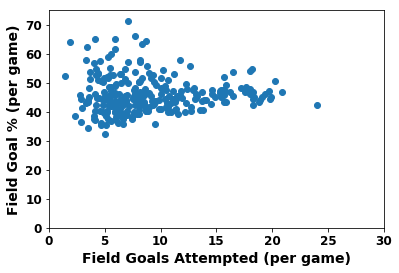

In [46]:
plt.scatter(db['fga'], db['fgp'])
plt.xlabel('Field Goals Attempted (per game)', fontsize=14, fontweight='bold')
plt.ylabel('Field Goal % (per game)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlim([0,30])
plt.ylim([0,75])

# Save to sql database
```python
sql_db = create_engine('sqlite:///16-17-nba_player_stats.db')
sql_db.echo = False

db.to_sql('16-17-nba_player_stats.db', sql_db)
```
# pickle it!
```python
db.to_pickle('16-17-nba_player_stats.pkl')
```